In [28]:
import pandas as pd

In [29]:
data=pd.read_csv("real_easte.csv",header=None)

In [30]:
data.columns=['id','area','price']

In [31]:
data=data.dropna()

In [32]:
data=data.drop_duplicates(subset=["area","price"])

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 0 to 9060
Data columns (total 3 columns):
id       859 non-null int64
area     859 non-null object
price    859 non-null object
dtypes: int64(1), object(2)
memory usage: 26.8+ KB


In [34]:
data

,id,area,price
0,2,68.68m²,2.2 tỷ
1,3,90m²,8.6 tỷ
2,4,60m²,2.39 tỷ
3,5,85.4m²,60 triệu/m²
4,6,45m²,5.1 tỷ
...,...,...,...
8799,11179,130m²,1 tỷ 50 triệu
8903,11318,75m²,800 triệu
8904,11319,140m²,1 tỷ 200 triệu
8905,11320,70m²,610 triệu


In [35]:
import seaborn as sns

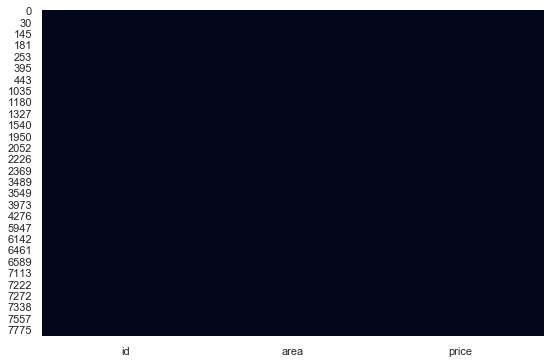

In [36]:
sns.heatmap(data.isnull(), cbar=False)


In [37]:
def convertPrice(area,price):
    area=re.sub("[^0-9^.]", "", area)
    area=float(area)
    if(area>1050):
        return 0
    output=0
    if ("triệu" in price and "tỷ" in price) :
        indexOfBili = price.index("tỷ");
        indexOfMili = price.index("triệu");
        output = float(price[0:indexOfBili].strip())*1000000 + float(price[indexOfBili+len('tỷ'):indexOfMili].strip())
    else:
        if("triệu/m" in price):
            if("triệu/m²" in price):
                output = float(price.replace(" triệu/m²", "").strip())*1000 * area;
            else:
                output = float(price.replace(" triệu/m2", "").strip())*1000 * area;
        else:
            if("ngàn/m" in price):
                indexOfMili = price.index("triệu");
                indexOfThousand=0
                if("ngàn/m²" in price):
                    indexOfThousand = price.index("ngàn/m²");
                else:
                    indexOfThousand = price.index("ngàn/m2");
                output = float(price[0:indexOfMili].strip())*1000 + float(price[indexOfMili+len('triệu'):indexOfThousand].strip())*1000*area
            else:
                if("triệu" in price and "tỷ" not in price):
                    indexOfMili = price.index("triệu");
                    thousand=((re.sub("[^0-9^.]","",price[indexOfMili+len('triệu'):]).strip()))
                    if(len(thousand)>0):
                        output = float(price[0:indexOfMili].strip())*1000 + float(thousand)
                    else:
                        output = float(price[0:indexOfMili].strip())*1000

                else:
                    if ("triệu" not in price and "tỷ" in price):
                        output = float(price.replace(" tỷ", "").strip())*1000000;
                    else:
                        return 0
    if output/1000>80000:
        return 0;
    return output

In [38]:
import re
id_list=[]
price_list=[]
area_list=[]
for row in data.values:
    price=convertPrice(str(row[1]),str(row[2]))
    if price!=0:
        id_list.append(row[0])
        price_list.append(price/1000)
        area_list.append(float(re.sub("[^0-9^.]", "", row[1])))

In [39]:
pd.DataFrame([ j for (i,j) in zip(area_list,id_list) if i >= 700 ]).to_clipboard()


In [40]:
len([ j for (i,j) in zip(area_list,id_list) if i >= 700 ])

25

In [41]:
from sklearn import preprocessing
import numpy as np

In [42]:

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [43]:
x_array=np.vstack((([NormalizeData(np.array(area_list))]), (([NormalizeData(np.array(price_list))])))).T

In [44]:
x_array=np.vstack((([np.array(area_list)]), (([np.array(price_list)])))).T

[Text(0, 0.5, 'price/million'), Text(0.5, 0, 'area/m2')]

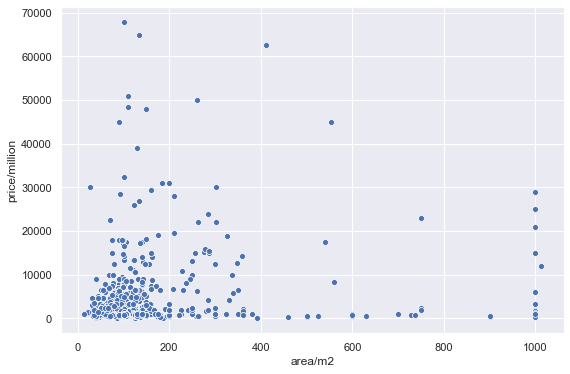

In [46]:
import matplotlib.pyplot as plt
df=pd.DataFrame({'area':x_array[:,0],"price":x_array[:,1]})
ax = sns.scatterplot(x="area", y="price",data=df)
ax.set(xlabel='area/m2', ylabel='price/million')

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = np.asarray(train_test_split(df['area'], df['price'], test_size=0.1))

In [48]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
print('Score: ', reg.score(X_test.values.reshape(-1,1), y_test.values.reshape(-1,1)))


Score:  0.04922090907388099


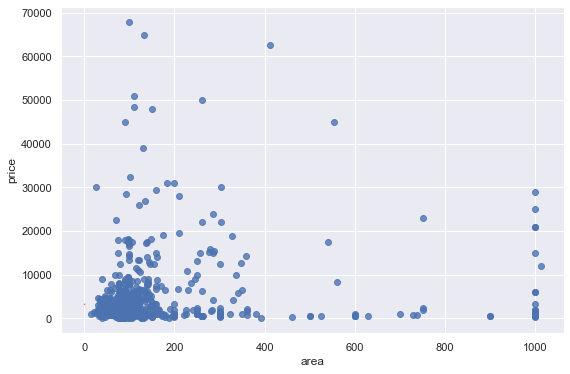

In [50]:
x_line = np.linspace(0,1,100).reshape(-1,1)
sns.regplot(x=df['area'], y=df['price'], data=df, fit_reg=False)
plt.plot(x_line, reg.predict(x_line))
plt.show()

In [51]:
from sklearn.preprocessing import PolynomialFeatures


In [52]:
poly = PolynomialFeatures(degree=3)
X_ = poly.fit_transform(X_train.values.reshape(-1,1))

In [53]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_, y_train.values.reshape(-1, 1))
y_pred = lin_reg_2.predict(X_)

In [54]:
from sklearn.metrics import r2_score
r2_score(y_train, y_pred)

0.0331172510129768

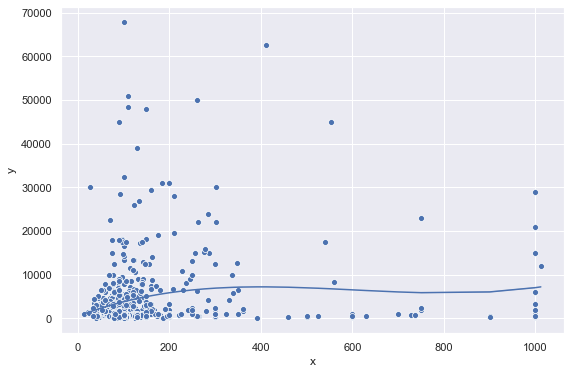

In [55]:
sns.set(rc={'figure.figsize':(9,6)})
ax=sns.scatterplot(x="x",y="y",data=pd.DataFrame.from_dict({"x":X_train.values,"y":y_train.values}))
ax=sns.lineplot(x="x",y="y",data=pd.DataFrame.from_dict({"x":X_train.values,"y":y_pred.flatten()}))